## Geologic model of Gottesacker from scratch in GemPy
***
Requires two csv files, one for orientations and one for interfaces. Column headings are case-sensitive and must match the headings used by GemPy:
<br>X Y Z formation                        ---> x, y, and z should be numbers not strings, formation is the formation name string
<br>X Y Z azimuth dip polarity formation   ---> azimuth=strike in degrees, polarity=1

In [27]:
#To-do:
#figure out how to efficiently get points from a geologic map
#georeference Nico's map and get coordinates and elevations for his strike & dip measurements
#import DEM (as tif (or shx?)) and geol map (as tif (or png?)) into python, make sure they are referenced to each other, using geopandas
#if possible import Nico's map with strike  dip measurement locations -might need to georeference first in ArcMap
#enable interactive point picking using bokeh (or matplotlib?)
#set formation first, then pick points interactively and append them to the dataframe for that formation, then run function again for each formation
#add ability to create points by adding or subtracting a formation's thickness from a point on the overlying or underlying formation?
#add x-sections - how to do this? georeference the lines in ArcMap? then what?

## Imports & Setup

In [28]:
# Import packages:

import sys, os
import numpy as np
import pandas as pn
import matplotlib.pyplot as plt
import theano
import geopandas as geo
import gdal
from copy import copy


sys.path.append("../../..")   #optional: if gempy has been downloaded from GitHub rather than installed normally, look for it in the folders above the current folder
import gempy as gp

# Import local packages:
import elisa

#embed matplotlib figures into notebooks:
%matplotlib inline            

575012.5 593962.5 5238037.5 5252987.5


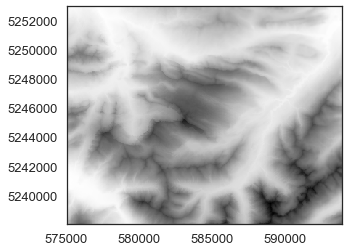

In [29]:
# Import data:

#Option 1: Import DEM from shapefile using geopandas:
dem = geo.read_file('dem50.shx', enabled_drivers=['GeoJSON', 'ESRI Shapefile']) #import shapefile (must be .shx not .shp, and must have all associated files) (also note DEM=DGM, but DEM is NOT the same as DSM)
im = dem['GRID_CODE'].values.reshape(300,380)   #reshape data from x,y,z to a grid
#get extent:
xmin=dem['x'].min()                             
xmax=dem['x'].max()
ymin=dem['y'].min()
ymax=dem['y'].max()
print(xmin,xmax,ymin,ymax)
plt.imshow(im, extent=(xmin,xmax,ymin,ymax)) #plot raster as image

Min z val is equal to nan val - making a copy of the array as floats with np.nan to find true min
[ 574987  594037 5237962 5253012     791    2381] [301 381]


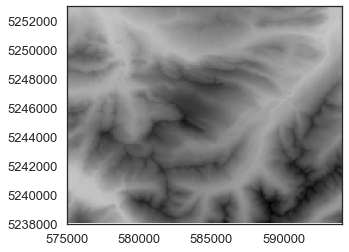

In [30]:
# Option 2:Import DEM from tif file using gdal:
demtif = gdal.Open('DEMraster50.tif')    #DEM must be rectangular tif 


extent, res = elisa.gdal2geodata_extent(demtif)     #get extent and resolution info from dem using gdal
print(extent, res)
xmin=extent[0]                             
xmax=extent[1]
ymin=extent[2]
ymax=extent[3]
zmin=extent[4]
zmax=extent[5]
plt.imshow(demtif.ReadAsArray(), extent=(xmin,xmax,ymin,ymax)) #plot raster as image

In [31]:
geo_data = gp.InputData([xmin,xmax, ymin,ymax, zmin,zmax], [89, 56, 50],        #set x,y,z min and max extent, and x,y,z resolution (can use info from DEM)
                       path_i='gottesacker_interfaces.csv',                     #csv file for interface points: must be at bottom of a layer, col names are case sensitive, must include at least 2 points per unit
                       path_o='gottesacker_orientations.csv')                   #csv file for orientation points: col names are case sensitive, must include at least one point per unit 

../../..\gempy\gempy_front.py:927: FutureWarning: gempy plotting functionality will be moved in version 1.2, use gempy.plotting module instead
  warnings.warn("gempy plotting functionality will be moved in version 1.2, use gempy.plotting module instead", FutureWarning)


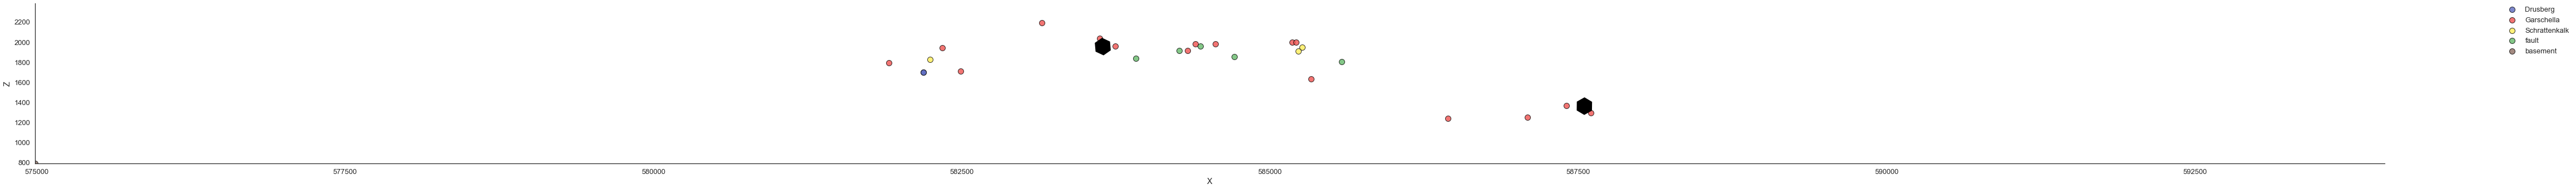

In [32]:
# View geologic info:
gp.get_data(geo_data, itype='formations')   #list formations
geo_data.interfaces.head()                  #display first few rows of geo_data dataframe
gp.plot_data(geo_data)                      #plot geo_data
#gp.plot_data_3D(geo_data)                  #plot geo_data in 3D using VTK (optional) (note: when a VTK interactive window is open, nothing else in the notebook can run - pause or close the window before continuing)

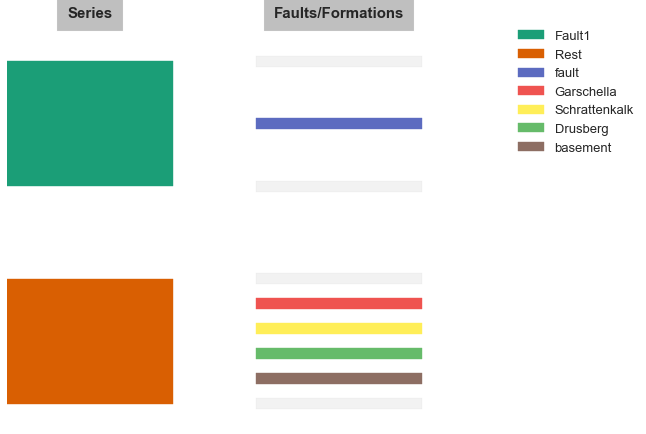

In [33]:
#Set series and formations stratigraphy for viewing:
#to-do: see how hard it would be to make colors customizable
gp.set_series(geo_data, {'Fault1': 'fault',
                         'Rest': ['Garschella', 'Schrattenkalk', 'Drusberg']}, verbose=1)  #series indicate BOTTOM of named layer



In [34]:
# Clean up data:
#need to add an orientation because each series needs to have at minimum one orientation and two interfaces

gp.set_orientation_from_interfaces(geo_data, [17,18,19] )            #calculate & append an orientation from 3 or more points (preferably close together but not in a line) in one series


,X,Y,Z,G_x,G_y,G_z,dip,azimuth,polarity,formation,series,formation_number,order_series,isFault,annotations,formation_value
2,584586.93,5.247729e+06,1851.333333,-0.421298,0.516779,0.745283,41.816559,320.811737,1.0,fault,Fault1,1,1,True,"${\bf{x}}_{\beta \,{\bf{1}},0}$",1
0,587549.48,5.246858e+06,1360.000000,0.012507,0.358150,0.933580,21.000000,2.000000,1.0,Garschella,Rest,2,2,False,"${\bf{x}}_{\beta \,{\bf{2}},0}$",2
1,583644.48,5.245876e+06,1953.000000,-0.086824,0.150384,0.984808,10.000000,330.000000,1.0,Garschella,Rest,2,2,False,"${\bf{x}}_{\beta \,{\bf{2}},1}$",2


## Create model

In [35]:
# Interpolate data:
#Caution: takes a while because has to compile. 
#only have to compile once UNLESS change presence of faults or not (number of faults doesn't matter - can change the number of fms & faults afterwards)
#but have to compile after data is imported 
#if changes are made to geo_data after this step, use update_interpolator (see below)

interp_data = gp.InterpolatorData(geo_data, compile_theano=True,
                                  theano_optimizer='fast_compile', is_lith=True, is_fault=True)


Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  1


In [9]:
# Optional: if changes are made to geo_data, can update interpolation without re-compiling:
interp_data.update_interpolator(geo_data)    

In [36]:
# Optional: set faults to be finite:
inf_factor = interp_data.interpolator.tg.inf_factor.get_value()     #fault extent is controlled by an infinity factor (default=10, which is larger than model scale)
inf_factor[0]=0                                                     #set infinity factor to 0 to make faults finite
interp_data.interpolator.tg.inf_factor.set_value(np.zeros(10, dtype="int32"))   #update value 
interp_data.interpolator.tg.inf_factor.get_value()                              #display new values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [37]:
# Compute model:
lith, fault = gp.compute_model(interp_data)  #lith is two arrays (each with dim: model extent) with a formation number assigned to each cell

In [ ]:
# Display model results:
gp.plotting.plot_section(geo_data, lith[0], 25, plot_data=True, direction='z')   #as cross-section 
ver, sim = gp.get_surfaces(interp_data, lith[1], fault[1])                       #create 3D objects for plotting
gp.plotting.plot_surfaces_3D_real_time(geo_data, interp_data, ver, sim)          #display in 3D with VTK

## Project and crop with topography

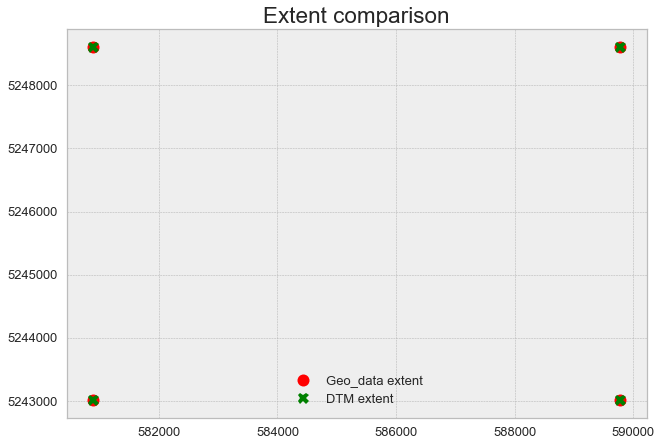

Extent of geo_data and DTM match. You may continue!


C:\Users\Chloe\Documents\GitHub\gempy\notebooks\prototype_notebooks\Chloe_Gottesacker\elisa.py:71: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  #print(shape)


array([[5.8093750e+05, 5.2485625e+06, 1.0000000e+00],
       [5.8103750e+05, 5.2485625e+06, 1.0000000e+00],
       [5.8113750e+05, 5.2485625e+06, 1.0000000e+00],
       ...,
       [5.8953750e+05, 5.2430625e+06, 1.0000000e+00],
       [5.8963750e+05, 5.2430625e+06, 1.0000000e+00],
       [5.8973750e+05, 5.2430625e+06, 1.0000000e+00]])

In [12]:
#to see this working - use DEMraster100.tif for dem, and use same extent for geo_data

import gdal
hallo = gdal.Open('DEMraster100.tif')    #DEM must be tif (go back to ArcMap & export a 50m resolution square tif (NOT cropped to watershed boundaries))
extent, res = elisa.gdal2geodata_extent(hallo)
xmin=extent[0]                             
xmax=extent[1]
ymin=extent[2]
ymax=extent[3]
zmin=extent[4]
zmax=extent[5]
geo_data = gp.InputData([xmin,xmax, ymin,ymax, zmin,zmax], [89, 56, 50],        #set x,y,z min and max extent, and x,y,z resolution (can use info from DEM)
                       path_i='gottesacker_interfaces.csv',                     #csv file for interface points: must be at bottom of a layer, col names are case sensitive, must include at least 2 points per unit
                       path_o='gottesacker_orientations.csv')                   #csv file for orientation points: col names are case sensitive, must include at least one point per unit 

elisa.compare_extent(hallo, geo_data)
cropped = hallo
cropped.ReadAsArray()[cropped.ReadAsArray() == 32767] = 1000
cropped.ReadAsArray()
g = elisa.tif2xyz('xyz', cropped)
g.reshape(-1, 3)
g2 = g.reshape(-1, 3)
g2[g2[:,2] == 32767, 2] = 1
g2

In [13]:
lith2, fault2 = gp.compute_model_at(g2, interp_data)  #will need to change all following lith to lith2 etc. (for geologic map)
#be careful with overwriting 


In [14]:
g.shape

(56, 89, 3)

In [15]:
56 * 89

4984

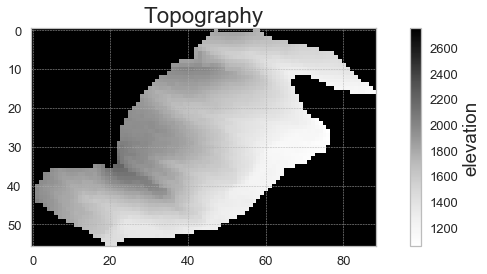

In [16]:
plt.figure(figsize=(12,4))
vdtm = plt.imshow(cropped.ReadAsArray(), vmax=2750)
plt.title("Topography")
cbar = plt.colorbar(vdtm)
cbar.set_label('elevation')

In [17]:
lb = lith[0].reshape(geo_data.resolution)

ValueError: cannot reshape array of size 4984 into shape (89,56,50)

In [25]:
89*56

4984

In [18]:
extent_dtm, res_dtm = elisa.gdal2geodata_extent(cropped)

In [19]:
dtm = cropped.ReadAsArray()
dtm[dtm==32767] = 1056

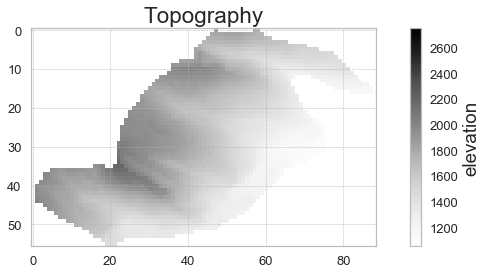

In [20]:
plt.figure(figsize=(12,4))
vdtm = plt.imshow(dtm, vmax=2750)
plt.title("Topography")
cbar = plt.colorbar(vdtm)
cbar.set_label('elevation')

In [21]:
from copy import copy
def height_ind(dtm, zs):
    '''calculate 'indices': array with shape (ext1, ext2) where the values
    are similar if the elevation is similar.'''  
    #zs = np.linspace(geo_data.extent[4], geo_data.extent[5], lb.shape[2])
    #dz = geo_data.extent[5] - geo_data.extent[4])/geo_data.resolution[2]
    # dz is number of points in z direction
    dz = (zs[-1] - zs[0]) / len(zs)
    #2. substract minimum value (here -1000) from each value of dtm and divide it by dz
    dtm_v = (dtm - zs[0]) / dz
    return dtm_v.astype(int)


def calculate_geomap(lb, dtm, geo_data, plot=True):
    zs = np.linspace(geo_data.extent[4], geo_data.extent[5], lb.shape[2])
    indices = height_ind(dtm,zs).T   
    geomap = np.zeros((lb.shape[0],lb.shape[1]))
    for x in range(lb.shape[0]):
        for y in range(lb.shape[1]):
            geomap[x,y] = lb[x,y,indices[x,y]]   
    if plot:
        plt.imshow(geomap.T, origin="upper", cmap=gp.plotting.colors.cmap, norm=gp.plotting.colors.norm)
        plt.title("Geological map")    
    return geomap.T  

def extend_lithblock(lb, factor):
    fertig2 = []
    for i in range(0,lb.shape[2]):
        lb_sub=lb[:,:,i]
        fertig = []
        for j in range(0, lb.shape[0]):
            y = np.repeat(lb_sub[j,:], factor)
            fertig = np.append(fertig, [y]*factor)
        fertig = fertig.reshape(lb.shape[0]*factor, lb.shape[1]*factor)
        fertig2.append(fertig)
        fertig2.append(fertig)
        fertig2.append(fertig)
        fertig2.append(fertig)
    return np.dstack(fertig2)

def mask_lith_block_above_topo(lb, geo_data, dtm):
    '''hier wird allen Werten die oberhalb der topographie 
    liegen ein minus eins zugewiesen und das dann maskiert'''
    zs = np.linspace(geo_data.extent[4], geo_data.extent[5], lb.shape[2])
    indices = height_ind(dtm,zs).T

    geoblock = copy(lb)
    for x in range(lb.shape[0]):
        for y in range(lb.shape[1]):
            z = indices[x,y]
            geoblock[x,y,z:] = -1
    
    return np.ma.masked_where(geoblock < 0, geoblock)

In [22]:
np.unique(height_ind(dtm,np.linspace(geo_data.extent[4], geo_data.extent[5], lb.shape[2])).T)

NameError: name 'lb' is not defined

In [23]:
geomap = calculate_geomap(lb,dtm, geo_data, plot = True)


NameError: name 'lb' is not defined

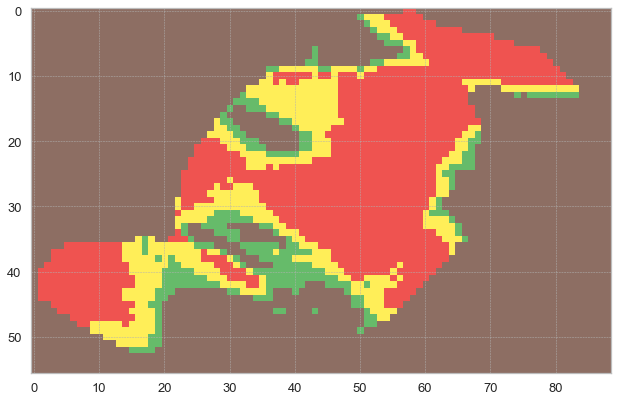

In [135]:
plt.imshow(lith[0].reshape(56, 89),  origin="upper", cmap=gp.plotting.colors.cmap, norm=gp.plotting.colors.norm)

In [96]:
dtm

array([[1056, 1056, 1056, ..., 1056, 1056, 1056],
       [1056, 1056, 1056, ..., 1056, 1056, 1056],
       [1056, 1056, 1056, ..., 1056, 1056, 1056],
       ...,
       [1056, 1056, 1056, ..., 1056, 1056, 1056],
       [1056, 1056, 1056, ..., 1056, 1056, 1056],
       [1056, 1056, 1056, ..., 1056, 1056, 1056]], dtype=int16)

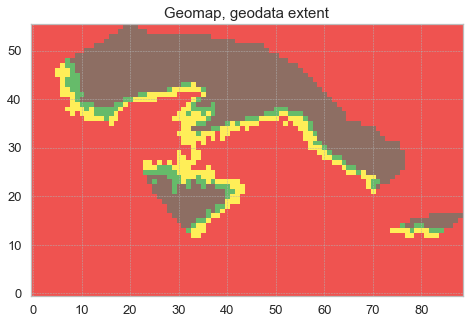

In [71]:
plt.figure(1, figsize = (10,5))
plt.imshow(geomap, origin="lower", cmap=gp.plotting.colors.cmap, norm=gp.plotting.colors.norm)
plt.title("Geomap, geodata extent", fontsize = 15)   

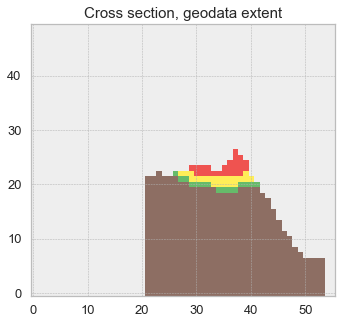

In [94]:
geoblock = mask_lith_block_above_topo(lb, geo_data, dtm)
plt.figure(1, figsize = (10,5))
fig = plt.imshow(geoblock[25,:,:].T, origin="lower", cmap=gp.plotting.colors.cmap,norm=gp.plotting.colors.norm)
plt.title("Cross section, geodata extent", fontsize = 15)  

In [73]:

lb.shape

(89, 56, 50)